In [ ]:
#Import der erforderlichen Module
import gym
import numpy as np
import random
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from keras.layers import Dense
from keras.models import Sequential
from collections import deque

Der folgende Code ist von diesen Quellen inspiriert:
- https://huggingface.co/learn/deep-rl-course/unit2/hands-on?fw=pt

In [45]:
#Initalisierung der Variablen

#Umgebung
env = gym.make("Taxi-v3", render_mode="rgb_array")
state_size = env.observation_space.n
action_size = env.action_space.n
gamma = 0.95

# Training Parameter
episodes = 10             # Mehr Episoden ohne externe Rechenleistung nicht möglich
learning_rate = 0.7
batch_size = 32
memory_buffer = deque(maxlen=2500)

# Evaluation Parameter
reward_lst=[]

# Exploration Parameter
max_epsilon = 1.0
min_epsilon = 0.05
decay_rate = 0.0005
exploration_rate = 1.0

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Der folgende Code ist von diesen Quellen inspiriert:
- https://github.com/hamedmokazemi/DeepQLearning_FrozenLake_1
- https://github.com/keon/deep-q-learning/tree/master

In [46]:
#DQN Agent
class DQN_Agent:
  def __init__(self, state_size, action_size, memory_buffer, learning_rate, exploration_rate, min_epsilon, max_epsilon, decay_rate, gamma):
          self.state_size= state_size
          self.action_size= action_size
          self.memory = memory_buffer
          self.learning_rate = learning_rate
          self.epsilon = exploration_rate
          self.min_eps = min_epsilon
          self.max_eps = max_epsilon
          self.eps_decay = decay_rate
          self.gamma = gamma
          self.model = self.model()

  def model(self):
          model = Sequential()
          model.add(Dense(32, input_dim=self.state_size, activation='relu'))
          model.add(Dense(64, activation='relu'))
          model.add(Dense(32, activation='relu'))
          model.add(Dense(self.action_size, activation='linear'))
          model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
          return model

  def memorize(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

  def act(self, state):
      if np.random.rand() <= self.epsilon:
          return random.randrange(self.action_size)
      act_values = self.model.predict(state)
      return np.argmax(act_values)

  def func_epsilon(self):
      self.epsilon = (self.max_eps - self.min_eps) * np.exp(-self.eps_decay*e) + self.min_eps
      return self.epsilon

  def replay(self,batch_size):
      mini_batch = random.sample(self.memory, batch_size)
      for next_state, reward, done, state, action in mini_batch:
          target= reward
          if not done:
              target=reward + self.gamma* np.amax(self.model.predict(next_state))
          target_f= self.model.predict(state)
          target_f[0][action]= target
          self.model.fit(state, target_f, epochs=1, verbose=0)

      if self.epsilon > self.min_eps:
          self.func_epsilon()

In [47]:
#Übergabe der Parameter
DQN_Agent = DQN_Agent(state_size, action_size, memory_buffer, learning_rate, exploration_rate, min_epsilon, max_epsilon, decay_rate, gamma)

In [ ]:
#Trainingsschleife des Agenten
for e in range(episodes):
    state = env.reset()
    state_vector = [0]*state_size
    state_vector[state] = 1
    state= np.reshape(state_vector, [1, state_size])
    reward = 0
    done = False
    while not done:
        act = DQN_Agent.act(state)
        next_state, reward, done, info = env.step(act)
        next_state_vector = [0]*state_size
        next_state_vector[next_state] = 1
        next_state = np.reshape(next_state_vector, [1, state_size])
        DQN_Agent.memorize(next_state, reward, done, state, act)
        state = next_state
        if done:
            print(f'Episode: {e+1:4}/{episodes} , Reward: {reward}')
            break
    reward_lst.append(reward)

    if len(DQN_Agent.memory)> batch_size:
        DQN_Agent.replay(batch_size)

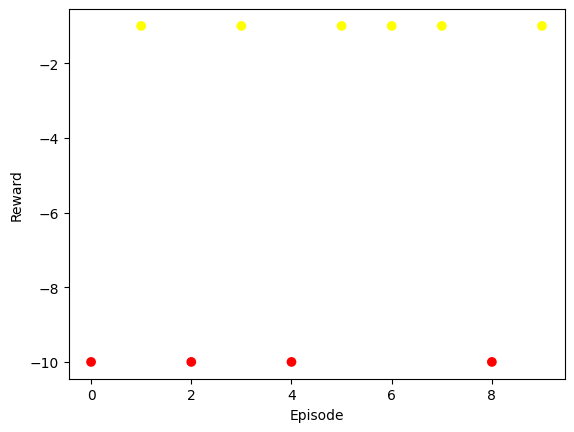

In [52]:
# Erzeugen des Index für die X-Achse und festlegen von verschiedenen Farben
episode = range(len(reward_lst))
colors = ['green' if reward > 0 else 'yellow' if reward == -1 else 'red' for reward in reward_lst]

# Erzeugen der Scatterplots
plt.scatter(episode, reward_lst, color=colors)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()